In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install scikit-learn pandas scipy matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
import kagglehub
jp797498e_twitter_entity_sentiment_analysis_path = kagglehub.dataset_download('jp797498e/twitter-entity-sentiment-analysis')

print('Data source import complete.')

Data source import complete.


In [ ]:
df_training = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
df_validation = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv')

df_training.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_content']
df_validation.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_content']

# Filtrar solo etiquetas válidas
etiquetas_validas = ['Positive', 'Neutral', 'Negative']
df_training = df_training[df_training['sentiment'].isin(etiquetas_validas)]
df_validation = df_validation[df_validation['sentiment'].isin(etiquetas_validas)]

df_training.dropna(inplace=True)
df_validation.dropna(inplace=True)

/tmp/ipython-input-6-520695124.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_training.dropna(inplace=True)


In [ ]:
def clean_text(text):
    #Limpieza básica de texto

    text = re.sub(r"http\S+|www\S+", "", text)#QUITAR URLs
    text = re.sub(r"@\w+|#\w+", "", text)#QUITAR MENCIONES, HASHTAGS, ETC.
    text = re.sub(r"[^A-Za-z\s]", "", text) #REMOVER CARÁCTERES ESPECIALES
    text = text.lower()#MANTENER TODO EN MINÚSCULAS
    text = re.sub(r"\s+", " ", text).strip() #QUITAR ESPACIOS
    return text

def preprocess_with_pos(text):
    #Lematizar y extraer POS tags

    text = clean_text(text)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token) > 2]
    pos_tags = [token.pos_ for token in doc if not token.is_stop and not token.is_punct and len(token) > 2]
    return " ".join(lemmas), pos_tags

def extract_pos_features(pos_list):
    #Extraer proporciones POS del tweet

    counter = Counter(pos_list)
    total = sum(counter.values())
    return pd.Series({
        'noun_ratio': counter['NOUN'] / total if total else 0,
        'verb_ratio': counter['VERB'] / total if total else 0,
        'adj_ratio': counter['ADJ'] / total if total else 0,
        'adv_ratio': counter['ADV'] / total if total else 0,
    })

In [ ]:
# ============================
# APLICAR A LOS DATOS
# ============================
print(" Procesando textos...")
df_training['lemmas'], df_training['pos_tags'] = zip(*df_training['tweet_content'].map(preprocess_with_pos))
df_validation['lemmas'], df_validation['pos_tags'] = zip(*df_validation['tweet_content'].map(preprocess_with_pos))

df_train_pos_feats = df_training['pos_tags'].apply(extract_pos_features)
df_val_pos_feats = df_validation['pos_tags'].apply(extract_pos_features)

🧹 Procesando textos...


In [ ]:
# ============================
# VECTORIZACIÓN TF-IDF
# ============================
print("Vectorizando con TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(df_training['lemmas'])
X_val_tfidf = vectorizer.transform(df_validation['lemmas'])

📊 Vectorizando con TF-IDF...


In [ ]:
# ============================
# COMBINAR TF-IDF + POS FEATURES
# ============================
print("Combinando features...")

X_train_combined = hstack([X_train_tfidf, df_train_pos_feats.to_numpy()])
X_val_combined = hstack([X_val_tfidf, df_val_pos_feats.to_numpy()])


📦 Combinando features...


In [ ]:

# ============================
# ESCALADO Y ENTRENAMIENTO
# ============================
print(" Entrenando modelo...")
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)

model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced'
)
model.fit(X_train_scaled, df_training['sentiment'])

🤖 Entrenando modelo...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [ ]:
# ============================
# EVALUACIÓN
# ============================
print(" Evaluando...")
y_pred = model.predict(X_val_scaled)
cm = confusion_matrix(df_validation['sentiment'], y_pred)
print("\n📋 Reporte de Clasificación:\n")
print(classification_report(df_validation['sentiment'], y_pred))


🧪 Evaluando...

📋 Reporte de Clasificación:

              precision    recall  f1-score   support

    Negative       0.85      0.90      0.87       266
     Neutral       0.90      0.87      0.89       285
    Positive       0.90      0.88      0.89       277

    accuracy                           0.88       828
   macro avg       0.88      0.88      0.88       828
weighted avg       0.88      0.88      0.88       828



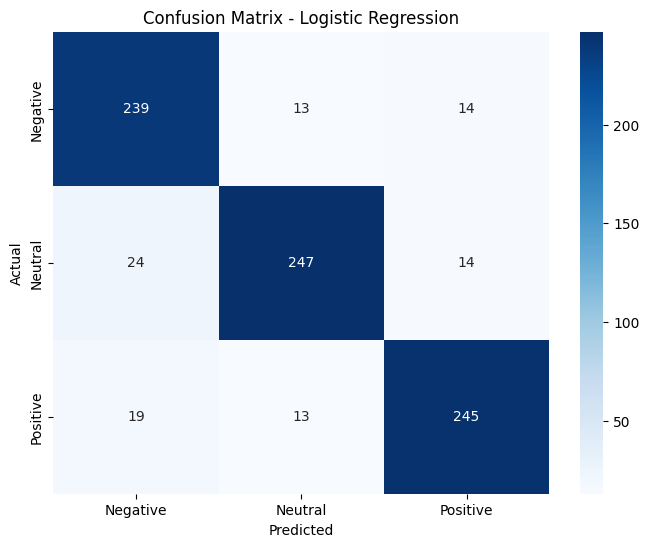

In [ ]:
# MATRIZ DE CONFUSIÓN
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()